In [9]:
from __future__ import division
import numpy as np
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.signal as spsig
import math
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import um21_lagmodel as uml
#%matplotlib inline
%matplotlib notebook

# Set up list of colours that are more colour-blind accessible.
CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
def calc_dispfrac2(rad_edge,seedff_norm,seedff_ind,heatff_norm,heatff_ind):
    """ Calculates viscous dissipation for each disk annulus normalised by the total summed over all radii. 
        Also calculates the fraction of dissipated power from radii inside the corona which go into heating 
        and seed photons. The sum of heating and seed luminosity fraction is not automatically kept equal
        to 1, to allow for unconstrained heating/cooling, e.g. from energy transport to the flow from outside 
        the coronal radius, but unity total fraction can be forced by specifying seedff_norm < 0, although
        care must be taken to ensure that heat_frac_flow remains < 1 at all radii.
        For seedff_norm = 0 no seed luminosity will be produced inside the corona."""
    rin = rad_edge[0]
    rad = np.sqrt(rad_edge[1:]*rad_edge[:-1])
    rad_area = np.pi*(np.square(rad_edge[1:])-np.square(rad_edge[:-1]))
    
    dispfrac = rad_area*(rad**(-3.0))   # Assumes zero-torque inner boundary
    dispfrac = dispfrac/np.sum(dispfrac)
    heat_frac_flow = heatff_norm*(rad/rin)**heatff_ind
    
    if (seedff_norm >= 0):
        seed_frac_flow = seedff_norm*(rad/rin)**heatff_ind
    else:
        seed_frac_flow = 1.0-heat_frac_flow
        
    return dispfrac, seed_frac_flow, heat_frac_flow


def calc_irf_centroid(irf,deltau):
    # Calculates IRF centroid lag seen by each radial bin
    irftau = np.where(deltau > 0, (np.cumsum(deltau)-deltau/2)*irf,np.cumsum(deltau)*irf)
    centroid = np.where(np.cumsum(irf) > 0, np.cumsum(irftau)/np.cumsum(irf),0.)
    return centroid

def plot_disk_seed_centroids(disk_irf,seed_irf,flux_irf,deltau_scale,lfreq,rad,sigrad,gamma_mean,gamma_ind,
                             en,e_seed):
    disk_cent = calc_irf_centroid(disk_irf,deltau_scale)
    seed_cent = calc_irf_centroid(seed_irf,deltau_scale)
    flux_cent = calc_irf_centroid(flux_irf,deltau_scale) 
    CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # Colour palette better for range of colour-blindness
    plt.figure()
    plt.plot(lfreq,lfreq*disk_cent,linewidth=2,color=CBcol[0],label='Disk')
    plt.plot(lfreq,lfreq*seed_cent,linewidth=2,color=CBcol[1],label='Seed')    
    plt.plot(lfreq,lfreq*seed_cent*(1+(gamma_mean*gamma_ind/(gamma_mean-1))),linewidth=2,color=CBcol[1],
             label='Corrected seed',linestyle='dashed')
    plt.plot(lfreq,lfreq*flux_cent,linewidth=2,color=CBcol[3],label='Flux at $E_{seed}$')
    u = gamma_mean*gamma_ind*(np.log(en/e_seed)-(gamma_mean-1)**(-1))
    lfrac = np.where(np.cumsum(seed_irf) > 0., 1./(np.cumsum(seed_irf)/np.sum(seed_irf)), 0.)
    plt.plot(lfreq,lfreq*seed_cent*(1-u)/(1+u*(lfrac-1)),color='magenta',linewidth=3,linestyle='dotted')
    for radval in sigrad:
        rsig, i_rsig = uml.find_nearest(rad,radval)
        plt.axvline(lfreq[i_rsig],color='gray',linewidth=2,linestyle='dotted')
    plt.xlabel(r'$\nu_{\rm signal}$',fontsize=14)
    plt.ylabel('-1 x IRF centroid delay (s)', fontsize=14)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.01,100.0)
    plt.ylim(0.001,1.0)
    plt.legend(fontsize=12)
#    plt.savefig('figs/irf_centroidvslfreq_spherical_monoseed_10rg.pdf',bbox_inches='tight')
    plt.show()
    return


def irf_plot_rebin(irf,deltau,minbin,i_rcor,i_rsigmax):
    if (np.sum(deltau[:i_rcor]) == 0.):
        tau_edges = np.zeros((i_rsigmax-i_rcor)+3)
        irf_rb = np.zeros(len(tau_edges)-1)
        tau_edges[-1:-3:-1] = [minbin,0.]
        tau_edges[-3::-1] = -1.*np.cumsum(deltau[i_rcor:i_rsigmax+1])
        irf_rb[-1] = np.sum(irf[0:i_rcor])/minbin
        irf_rb[-2::-1] = irf[i_rcor:i_rsigmax+1]/np.abs(np.diff(tau_edges[-2::-1]))
    else:
        tau_edges = np.zeros(i_rsigmax+2)
        irf_rb = np.zeros(len(tau_edges)-1)
        tau_edges[-2::-1] = -1.*np.cumsum(deltau[:i_rsigmax+1])
        irf_rb = irf[i_rsigmax::-1]/np.diff(tau_edges)
        
    return tau_edges, irf_rb

def run_setup_mono(rin,rout,nrad,rcor,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac):
    
    #First set up radial grid
    rad_edge = np.logspace(np.log10(rin), np.log10(rout), nrad+1)  # set up radial bin edges
    rad = np.sqrt(rad_edge[1:]*rad_edge[:-1])  # Define radial bin centres as geometric mean of bin edges
    rad_area = np.pi*(np.square(rad_edge[1:])-np.square(rad_edge[:-1]))
    disp_frac, seed_frac_flow, heat_frac_flow = \
        uml.calc_dispfrac(rad_edge,seedff_norm,seedff_ind,heatff_norm,heatff_ind) 
    # Normalised viscous dissipation and parameters for seed and heating fractions within coronal flow.
    # Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
    rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
    # Reset maximum signal radius to nearest radial bin value
    rsigmax, i_rsigmax = uml.find_nearest(rad,rsigmax)
    print("Coronal radius reset to nearest radial bin edge: ",rcor)
    print("Maximum signal radius reset to: ",rsigmax)
    # Calculate illumination of corona by disk and vice-versa
    omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
    cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
    print(np.sum(disp_frac[i_rcor:]*disktocor_frac[i_rcor:])/np.sum(disp_frac[i_rcor:])," of the disk flux is intercepted by the corona")
    print(np.sum(cortodisk_frac[i_rcor:])," of the coronal flux is intercepted by the disk")
    # Now calculate radial dependence of timing parameters and calculate propagation delays
    tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)
    deltau = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)
    # Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
    ldisk_disp, lseed_disp, lheat, ldisk_rev, lseed_rev =\
        uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,
                                      cortodisk_frac,seed_frac_flow,heat_frac_flow)
    print("Seed energy :",e_seed)
    print("Dissipation disk luminosity: ",np.sum(ldisk_disp))
    print("Dissipation seed luminosity: ",np.sum(lseed_disp))
    print("Coronal heating luminosity: ",np.sum(lheat))
    print("Disk luminosity due to heating by corona: ",np.sum(ldisk_rev))
    print("Seed luminosity due to heating by corona: ",np.sum(lseed_rev))
    
        # Calculate IRFs for the mono-energetic case
    gamma_mean, gamma_irf, flux_irf_mono, disk_irf_mono, seed_irf_mono =\
                    uml.calc_irfs_mono(gamma_par,e_seed,ens_mono,\
                                ldisk_disp,lseed_disp,lheat,ldisk_rev,lseed_rev)
    
    print("Mean gamma is:", gamma_mean)
    
    return gamma_mean, rad, tau, i_rcor, i_rsigmax, deltau, ldisk_disp,\
    lseed_disp, lheat, ldisk_rev, lseed_rev


def compare_irfs(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad):
    
    minbin = 1.0
    plt.figure()
    for x in geom_list:
        cor_geometry = x[0]
        geopar = x[1]
        rcor = geopar[0]
        colour_val = x[2]
        label_val = x[3]
    
        print("*******************************************************************")        
        print("Calculating for geometrical parameters: ",geopar)
        print("*******************************************************************")
        gamma_mean, rad, tau, i_rcor, i_rsigmax, deltau, ldisk_disp, lseed_disp,\
        lheat, ldisk_rev, lseed_rev = run_setup_mono(rin,rout,nrad,rcor,
                    rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)
        
        disk_irf = ldisk_disp + ldisk_rev
        seed_irf = lseed_disp + lseed_rev
        heat_irf = lheat
        tau_edges, disk_irf_rb = irf_plot_rebin(disk_irf,deltau,minbin,i_rcor,i_rsigmax)
        tau_edges, seed_irf_rb = irf_plot_rebin(seed_irf,deltau,minbin,i_rcor,i_rsigmax)
        tau_edges, heat_irf_rb = irf_plot_rebin(heat_irf,deltau,minbin,i_rcor,i_rsigmax)
        dummy_data = (tau_edges[1:] + tau_edges[:-1])/2.
        dtau = -0.5*(tau_edges[:-1]+tau_edges[1:])
        disk_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=np.abs(dtau)*disk_irf_rb, 
                    histtype='step',linestyle='solid',linewidth=2,color=colour_val,label=label_val)
        seed_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=np.abs(dtau)*seed_irf_rb,
                    histtype='step',linestyle='dotted',linewidth=2,color=colour_val)
        heat_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=np.abs(dtau)*heat_irf_rb,
                    histtype='step',linestyle='dashed',linewidth=2,color=colour_val)
        if (np.sum(deltau[:i_rcor]) == 0.):
            plt.scatter(np.mean(tau_edges[-2:]),disk_irf_rb[-1],marker='_',s=200,
                linewidth=3,linestyle='solid',color=colour_val)
            plt.scatter(np.mean(tau_edges[-2:]),seed_irf_rb[-1],marker='_',s=200,
                linewidth=3,linestyle='dotted',color=colour_val)
            plt.scatter(np.mean(tau_edges[-2:]),heat_irf_rb[-1],marker='_',s=200,
                linewidth=3,linestyle='dashed',color=colour_val)
        
    plt.yscale('log')
    plt.xscale('symlog', linthreshx=100., linscalex=0.5)
    plt.xlim(-1.*np.sum(deltau[i_rcor:i_rsigmax+1]),20.)
    plt.ylim(2e-3,0.3)
    plt.xticks([-1e5,-1e4,-1e3,-1e2],fontsize=11) 
    plt.yticks(fontsize=12)
    plt.tick_params(axis='x',labelsize=12, which='both', direction='in')
    plt.tick_params(axis='y',labelsize=12, which='both', direction='in', right=True)
    plt.xlabel('Delay ($R_g/c$)', fontsize=13)
    plt.ylabel(r'Response $\times c/R_{g} \times$ Delay', fontsize=13)
    if sigrad != None:
        for radius in sigrad:
            rsig, i_rsig = uml.find_nearest(rad,radius)
            tausig = np.sum(deltau[:i_rsig])
            plt.axvline(-1.*tausig,color='gray',linestyle='dashed',linewidth=2)
            radtxt = str(round(radius))+" $R_{g}$"
            plt.text(-1.*tausig,0.34,radtxt,fontsize=12,horizontalalignment='center')        

    plt.legend(fontsize=10,loc='upper left',title=leg_title)
    if figfile != None:
        plt.savefig(figfile,bbox_inches='tight')
    plt.show()    
    return        
        


In [6]:
# Set up starting parameters:
############################################
### Basic geometry and radial binning: #####
############################################
cor_geometry = uml.an_sphere
rin = 2.0  # Innermost radius for viscous dissipation (ISCO)
rout = 300.0 # Outermost radius for viscous dissipation - best to set large but with smaller rsigmax 
# to make linear rebinned IRFs manageable
nrad = 200 # Number of radial bins for viscous dissipation
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
hcor = 10.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 30.0  # Cone opening angle in degrees
#rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
#print("Coronal top radius : ",rtop)
geopar = [rcor]
################################################################################
### 'Timing model' parameters for driving signal generation and propagation ####
################################################################################
rsigmax = 300.0 # Maximum radius for inward-propagating signals to start from
t_scale= 5e-5 # Scaling between Rg/c units and actual time units (e.g. for timing in seconds, this is Rg/c in seconds,
# e.g. 5e-5 for a 10 solar mass BH)
min_deltau_frac = 0.25 # Minimum bin size (fraction of minimum propagation delay across a bin)
disk_tau_par = [100.,0.] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
disk_prop_par = [100.,0.] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [10., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

lor_model = 'continuous' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.4,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii
nirf_mult = 8 # IRF is this (must be power of 2) times bigger than next highest power of 2 bins corresponding to 
#  propagation time from max. signal radius.  Set high enough to ensure entire useful frequency range can be covered.

###########################################################################################
### 'Spectral model' parameters for disk absorbed flux and seed and heating in corona, ####
### photon index dependence on L_s/L_h and choice of energies for power-law fluxes and ####
### observed disk band. ###################################################################
###########################################################################################

disk_abs_frac = 0.7 # Fraction of incident flux on disk which is reprocessed into blackbody emission (= 1-albedo)
heatff_norm = 1.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into heating the corona (heat_frac_flow)
heatff_ind = 0.0 # Index for radial dependence of heat_frac_flow 
seedff_norm = 0.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into internal seed photons (seed_frac_flow)
# should be set to zero if using full energy-dependent model, as assumed internal seed spectrum 
# not yet implemented. Set to < 0 if you require seed_frac_flow = 1.-heat_frac_flow
seedff_ind = 0.0 # Index for radial dependence of seed_frac_flow 
gamma_par = [2.33,0.167] # gamma = gamma_par[0]*(L_s/L_h)^(gamma_par[1])
e_seed = 1.0
# Choose power-law energies for analytical calculation using mono-energetic bands 
# (must be equal or greater than e_seed):
ens_mono = np.array([1.,3.,9.,27.])*e_seed
# Specify pairs of energy bands to use for spectral-timing measurements. Band 0 is the disk, larger indices
# i corresponds to index i-1 in the array of monoenergetic bands for power-law analysis.
encomb = np.array([[2,0],[3,2],[4,3]])

Coronal radius reset to nearest radial bin edge:  9.939835534143139
Maximum signal radius reset to:  296.265462867623
0.06901737140358782  of the disk flux is intercepted by the corona
0.17195641070846157  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.41197833971469366
Dissipation seed luminosity:  0.028433662082322488
Coronal heating luminosity:  0.5880216602853063
Disk luminosity due to heating by corona:  0.10600344459646506
Seed luminosity due to heating by corona:  0.010734350378686933
Mean gamma is: 1.4821317205931228


<IPython.core.display.Javascript object>


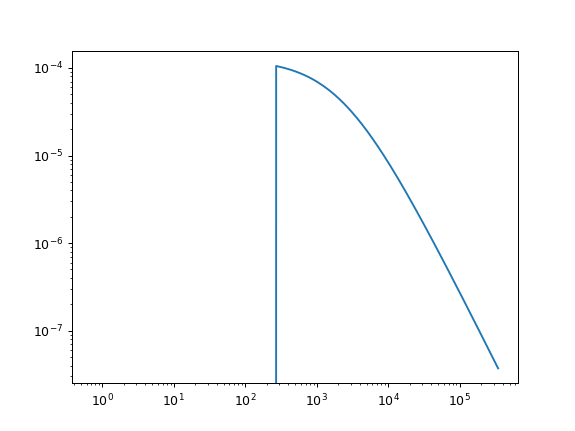

<IPython.core.display.Javascript object>


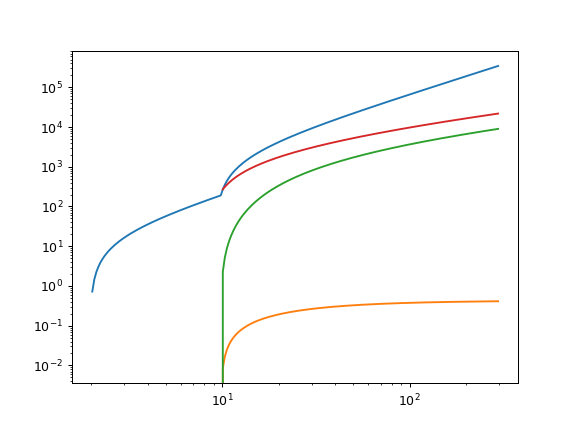

/Users/philu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [7]:
gamma_mean, rad, tau, i_rcor, i_rsigmax, deltau, ldisk_disp, lseed_disp, lheat, ldisk_rev, lseed_rev \
                    = run_setup_mono(rin,rout,nrad,rcor,
                    rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)

plt.figure()
plt.plot(np.cumsum(deltau),ldisk_disp/deltau)
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure()
plt.plot(rad,np.cumsum(deltau))
plt.plot(rad,np.cumsum(ldisk_disp))
plt.plot(rad,np.cumsum(np.cumsum(deltau)*ldisk_disp))
plt.plot(rad,np.cumsum(np.cumsum(deltau)*ldisk_disp)/np.cumsum(ldisk_disp))
plt.xscale('log')
plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


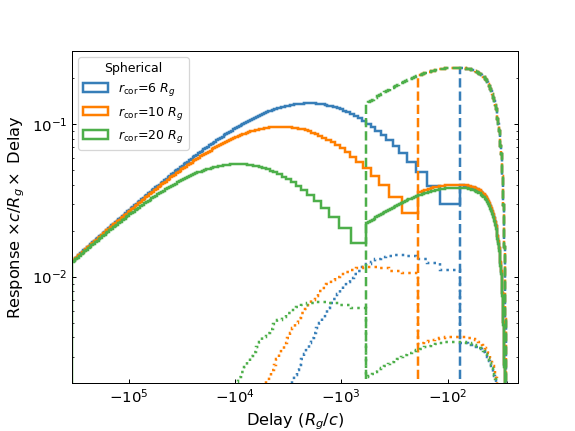

*******************************************************************
Calculating for geometrical parameters:  [6.0]
*******************************************************************
Coronal radius reset to nearest radial bin edge:  6.02240659026927
Maximum signal radius reset to:  296.265462867623
0.05939735412372971  of the disk flux is intercepted by the corona
0.17074468471729082  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.6060480538363964
Dissipation seed luminosity:  0.035997650869717644
Coronal heating luminosity:  0.39395194616360363
Disk luminosity due to heating by corona:  0.07341160838978068
Seed luminosity due to heating by corona:  0.00684954818333928
Mean gamma is: 1.608599558705458
*******************************************************************
Calculating for geometrical parameters:  [10.0]
*******************************************************************
Coronal radius reset to nearest radial bin edge:  9.939

In [8]:
# reset to equal disk rms per annulus normalised to get 0.3 total for 10 R_g r_cor.
# 
nvardisk = np.log(rsigmax/10.0)/(np.log(rout/rin)/nrad)
lor_par[1] = -1.0*lor_par[1]/np.sqrt(nvardisk)

radlist = [6.0,10.0,20.0]
collist = CBcol[:3]
lstylist = ['solid','dashed','dotted']
geom_list = [[uml.an_sphere,[radlist[0]],collist[0],
              r"$r_{\rm cor}$="+str(round(radlist[0]))+" $R_{g}$"]]
i = 1
for radval in radlist[1:]:
    radtxt = r"$r_{\rm cor}$="+str(round(radval))+" $R_{g}$"
    geom_list.append([uml.an_sphere,[radval],collist[i],radtxt])
    i = i+1
    
ens_mono = np.array([e_seed,3.0,9.0])
encomb = np.array([[1,0],[3,2]])

#figfile = 'figs/lagspsd_sphmono_geomcompare.pdf'
figfile = None
leg_title='Spherical'
sigrad = None
compare_irfs(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad)

In [ ]:
collist = CBcol[:4]
rcor = 10.0
hcorlist = [6.0,15.0,30.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [30.,30.,30.]  # Cone opening angle in degrees
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))

geopar = [rcor,hcorlist[0],rtoplist[0],1000,1000]
geom_list = [[uml.inv_cone,geopar,collist[0],r"$h_{\rm cor}$="+str(round(hcorlist[0]))+" $R_{g}$"]]
i = 1
for hcorval in hcorlist[1:]:
    geopar = [rcor,hcorlist[i],rtoplist[i],1000,1000]
    radtxt = r"$h_{\rm cor}$="+str(round(hcorval))+" $R_{g}$"
    geom_list.append([uml.inv_cone,geopar,collist[i],radtxt])
    i = i+1

ens_mono = np.array([e_seed,3.0,9.0])
encomb = np.array([[1,0],[3,2]])

#figfile = 'figs/lagspsd_cylindmono_geomcompare.pdf'
figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=45^{\circ}$'

sigrad = [100.0,50.0,20.0,10.0,3.0]
compare_irfs(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad)

In [ ]:
rcor = 10.0
hcorlist = [10.0,10.0,10.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [0.,20.,45.]  # Cone opening angle in degrees
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
collist = CBcol[:3]
#collist = ['red','gray','orange','purple']
geopar = [rcor,hcorlist[0],rtoplist[0],1000,1000]
geom_list = [[uml.inv_cone,geopar,collist[0],r"$\theta_{\rm cor}$="+str(round(angle_list[0]))+"$^{\circ}$"]]
i = 1
for hcorval in hcorlist[1:]:
    geopar = [rcor,hcorlist[i],rtoplist[i],1000,1000]
    radtxt = r"$\theta_{\rm cor}$="+str(round(angle_list[i]))+"$^{\circ}$"
    geom_list.append([uml.inv_cone,geopar,collist[i],radtxt])
    i = i+1

ens_mono = np.array([e_seed,3.0,9.0])
encomb = np.array([[1,0],[3,2]])

#figfile = 'figs/lagspsd_cylindmono_geomcompare.pdf'
figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $h_{\rm cor}=10$ $R_{g}$'

sigrad = [100.0,50.0,20.0,10.0,3.0]
compare_irfs(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad)

In [ ]:
#First set up radial grid
rad_edge = np.logspace(np.log10(rin), np.log10(rout), nrad+1)  # set up radial bin edges
rad = np.sqrt(rad_edge[1:]*rad_edge[:-1])  # Define radial bin centres as geometric mean of bin edges
rad_area = np.pi*(np.square(rad_edge[1:])-np.square(rad_edge[:-1]))
disp_frac, seed_frac_flow, heat_frac_flow = \
    uml.calc_dispfrac(rad_edge,seedff_norm,seedff_ind,heatff_norm,heatff_ind) 

# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)

# Reset maximum signal radius to nearest radial bin value
rsigmax, i_rsigmax = uml.find_nearest(rad,rsigmax)
print("Coronal radius reset to nearest radial bin edge: ",rcor)
print("Maximum signal radius reset to: ",rsigmax)

# Calculate illumination of corona by disk and vice-versa
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)

cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)

print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")

# Now calculate radial dependence of timing parameters and calculate propagation delays
tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)

deltau = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)

# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp, lseed_disp, lheat, ldisk_rev, lseed_rev =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Assign maximum kT, seed energy for monochromatic seeds (analytical model), kT vs radius and total disk L
kT_max = 0.3
e_seed = 2.82*kT_max


print("Dissipation disk luminosity: ",np.sum(ldisk_disp))
print("Dissipation seed luminosity: ",np.sum(lseed_disp))
print("Coronal heating luminosity: ",np.sum(lheat))
print("Disk luminosity due to heating by corona: ",np.sum(ldisk_rev))
print("Seed luminosity due to heating by corona: ",np.sum(lseed_rev))

In [ ]:
# Set up energy array for full energy-dependent calculation:
en_min = 0.01
en_max = 100.0
nenbins = 200
ebounds = np.logspace(np.log10(en_min),np.log10(en_max),nenbins+1)
ens = np.sqrt(ebounds[1:]*ebounds[:-1])

# Choose power-law energies for analytical calculation using mono-energetic bands 
# (must be equal or greater than e_seed):
ens_mono = np.array([e_seed,2.5,7.5,22.5])

# Calculate IRFs 
gamma_mean, gamma_irf, flux_irf, disk_irf, seed_irf =\
                    uml.calc_irfs_mono(gamma_par,e_seed,ens_mono,\
                                ldisk_disp,lseed_disp,lheat,ldisk_rev,lseed_rev)
print("Mean gamma is:", gamma_mean)

for varname in [gamma_mean, gamma_irf, flux_irf, disk_irf, seed_irf]:
    print("Shapes 2 :",np.shape(varname))

# Specify pairs of energy bands to use for spectral-timing measurements. Band 0 is the disk, larger indices
# i corresponds to index i-1 in the array of monoenergetic bands for power-law analysis.
encomb = np.array([[1,0],[3,2],[4,2]]) # Set array of energy combinations for spectral-timing outputs

# Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
freq, phlag, tlag, psd_ci, psd_ref, mod_sig_psd, irf_nbins, irf_binedgefrac, deltau_scale, dt, nirf,\
        ci_irf, ci_mean, ci_outer =\
        uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf,disk_irf,gamma_irf,
                                deltau,min_deltau_frac,i_rsigmax,lfreq,q,rms,t_scale)




In [ ]:
#plot_disk_seed_centroids(disk_irf,seed_irf,flux_irf[2,:],deltau_scale,lfreq,rad,gamma_mean,gamma_par[1],
#                             ens_mono[1],e_seed)

sigrad = [100.0,50.0,25.0,15.0,12.0]

plot_disk_seed_centroids((ldisk_disp+ldisk_rev),(lseed_disp+lseed_rev),flux_irf[0,:],deltau_scale,lfreq,rad,
                         sigrad,gamma_mean,gamma_par[1],ens_mono[0],e_seed)

plt.figure()
#plt.plot(lfreq,ldisk_disp*np.cumsum(deltau)/np.sum(np.cumsum(deltau)*ldisk_disp))

#lseed_temp = disktocor_frac*ldisk_disp
lseed_temp = 1.*(lseed_disp+lseed_rev)
ldisk_temp = 1.*(ldisk_disp+ldisk_rev)
#lseed_temp = 1.*(lseed_disp)
#ldisk_temp = 1.*(ldisk_disp)
disk_irftau = np.where(deltau > 0, (np.cumsum(deltau)-deltau/2)*ldisk_temp,np.cumsum(deltau)*ldisk_temp)
seed_irftau = np.where(deltau > 0, (np.cumsum(deltau)-deltau/2)*lseed_temp,np.cumsum(deltau)*lseed_temp)

plt.plot(lfreq,lfreq*np.cumsum(disk_irftau),color='red')
plt.plot(lfreq,lfreq*np.cumsum(seed_irftau),color='black')
plt.plot(lfreq,lfreq*np.cumsum(lseed_temp),linestyle='dotted',color='black')
plt.plot(lfreq,lfreq*np.cumsum(ldisk_temp),linestyle='dotted',color='red')
plt.plot(lfreq,lfreq*np.cumsum(disk_irftau)/np.cumsum(ldisk_temp),color='red',linestyle='dashed')
plt.plot(lfreq,lfreq*np.cumsum(seed_irftau)/np.cumsum(lseed_temp),color='black',linestyle='dashed')

#plt.plot(lfreq,(np.cumsum(disk_irftau)/np.cumsum(ldisk_temp))/(np.cumsum(seed_irftau)/np.cumsum(lseed_temp)),
#
#plt.plot(lfreq,disktocor_frac*ldisk_disp*np.cumsum(deltau)/np.sum(np.cumsum(deltau)*disktocor_frac*ldisk_disp))
#plt.plot(lfreq,disktocor_frac*ldisk_disp/np.sum(disktocor_frac*ldisk_disp))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
cor_geometry = uml.inv_cone

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 6.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp1, lseed_disp1, lheat1, ldisk_rev1, lseed_rev1 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp2, lseed_disp2, lheat2, ldisk_rev2, lseed_rev2 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 40.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp3, lseed_disp3, lheat3, ldisk_rev3, lseed_rev3 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

ldisk_list = [ldisk_disp1+ldisk_rev1,ldisk_disp2+ldisk_rev2,ldisk_disp3+ldisk_rev3]
lseed_list = [lseed_disp1+lseed_rev1,lseed_disp2+lseed_rev2,lseed_disp3+lseed_rev3]
lheat_list = [lheat1,lheat2,lheat3]

In [ ]:
def plot_irfs_list(disk_irfs,seed_irfs,heat_irfs,lstyles,deltau,minbin,i_rcor,i_rsigmax,sigrad,rad):
    CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # Colour palette better for range of colour-blindness
    plt.figure()
    for i, disk_irf in enumerate(disk_irfs):
        seed_irf = seed_irfs[i]
        heat_irf = heat_irfs[i]
        tau_edges, disk_irf_rb = irf_plot_rebin(disk_irf,deltau,minbin,i_rcor,i_rsigmax)
        tau_edges, seed_irf_rb = irf_plot_rebin(seed_irf,deltau,minbin,i_rcor,i_rsigmax)
        tau_edges, heat_irf_rb = irf_plot_rebin(heat_irf,deltau,minbin,i_rcor,i_rsigmax)
        dummy_data = (tau_edges[1:] + tau_edges[:-1])/2.
        dtau = -0.5*(tau_edges[:-1]+tau_edges[1:])
        dtau[-1] = 1
        print(heat_irf_rb,dtau)
        disk_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=np.abs(dtau)*disk_irf_rb, 
                    histtype='step',linestyle=lstyles[i],linewidth=2,color=CBcol[0],label='Disk')
        seed_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=np.abs(dtau)*seed_irf_rb,
                    histtype='step',linestyle=lstyles[i],linewidth=2,color=CBcol[1],label='Seed')
        heat_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=np.abs(dtau)*heat_irf_rb,
                    histtype='step',linestyle=lstyles[i],linewidth=2,color=CBcol[2],label='Coronal heating')
        plt.scatter(np.mean(tau_edges[-2:]),disk_irf_rb[-1],marker='_',s=500,
                linewidth=2,linestyle=lstyles[i],color=CBcol[0])
        plt.scatter(np.mean(tau_edges[-2:]),seed_irf_rb[-1],marker='_',s=500,
                linewidth=2,linestyle=lstyles[i],color=CBcol[1])
        plt.scatter(np.mean(tau_edges[-2:]),heat_irf_rb[-1],marker='_',s=500,
                linewidth=2,linestyle=lstyles[i],color=CBcol[2])
    plt.yscale('log')
    plt.xscale('symlog', linthreshx=1e3, linscalex=0.5)
    plt.xlim(-1.*np.sum(deltau[i_rcor:i_rsigmax+1]),np.sum(deltau[:i_rcor])+1000.)
    plt.ylim(4e-5,1)
    plt.xticks([-1e5,-1e4,-1e3,0],fontsize=11) 
    plt.yticks(fontsize=12)
    plt.xlabel('Delay ($R_g/c$)', fontsize=13)
    plt.ylabel(r'Response [fraction of $L_{\rm tot}$] ($c/R_g$)', fontsize=13)
    for radius in sigrad:
        rsig, i_rsig = uml.find_nearest(rad,radius)
        tausig = np.sum(deltau[:i_rsig+1])
        plt.axvline(-1.*tausig,color='gray',linestyle='dotted',linewidth=2)
        radtxt = str(round(radius))+" $R_{g}$"
        plt.text(-1.*tausig,3.0,radtxt,fontsize=12,horizontalalignment='center')
#    plt.legend(fontsize=12)
#    plt.savefig('figs/irf_5radii_spherical_monoseed_10rg.pdf',bbox_inches='tight')
    plt.show()    
    return

lstyles = ['solid','dotted','dashed']
#plot_irfs_list(ldisk_list,lseed_list,lheat_list,lstyles,deltau,1.0,i_rcor,i_rsigmax,sigrad,rad)


In [ ]:
cor_geometry = uml.inv_cone

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 0.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp1, lseed_disp1, lheat1, ldisk_rev1, lseed_rev1 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 20.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp2, lseed_disp2, lheat2, ldisk_rev2, lseed_rev2 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp3, lseed_disp3, lheat3, ldisk_rev3, lseed_rev3 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

ldisk_list = [ldisk_disp1+ldisk_rev1,ldisk_disp2+ldisk_rev2,ldisk_disp3+ldisk_rev3]
lseed_list = [lseed_disp1+lseed_rev1,lseed_disp2+lseed_rev2,lseed_disp3+lseed_rev3]
lheat_list = [lheat1,lheat2,lheat3]

plot_irfs_list(ldisk_list,lseed_list,lheat_list,lstyles,deltau,1.0,i_rcor,i_rsigmax,sigrad,rad)

In [ ]:
cor_geometry = uml.an_sphere

# Calculate illumination of corona by disk and vice-versa
rcor = 6.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
print("radius",rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 0.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp1, lseed_disp1, lheat1, ldisk_rev1, lseed_rev1 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
print("radius",rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 20.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp2, lseed_disp2, lheat2, ldisk_rev2, lseed_rev2 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 20.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
print("radius",rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp3, lseed_disp3, lheat3, ldisk_rev3, lseed_rev3 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

ldisk_list = [ldisk_disp1+ldisk_rev1,ldisk_disp2+ldisk_rev2,2*(ldisk_disp3+ldisk_rev3)]
lseed_list = [lseed_disp1+lseed_rev1,lseed_disp2+lseed_rev2,lseed_disp3+lseed_rev3]
lheat_list = [lheat1,lheat2,lheat3]
sigrad = [100.0,50.0,25.0,15.0,12.0,10.0]
plot_irfs_list(ldisk_list,lseed_list,lheat_list,lstyles,deltau,1.0,i_rcor,i_rsigmax,sigrad,rad)

In [ ]:
# Plot frequency-dependent spectral-timing products
%matplotlib notebook
plt.figure()
plt.plot(freq,phlag[0,:],color="red",linestyle="dashed")
plt.plot(freq,phlag[1,:],color="green",linestyle="dashed")
plt.plot(freq,phlag[2,:],color="blue",linestyle="dashed")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase lag (radians)')
plt.yscale('linear')
plt.xscale('log')
plt.show()

plt.figure()
plt.plot(freq,tlag[0,:],color="red",linestyle="dashed")
plt.plot(freq,tlag[1,:],color="green",linestyle="dashed")
plt.plot(freq,tlag[2,:],color="blue",linestyle="dashed")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Time lag (s)')
plt.yscale('symlog')
plt.xscale('log')
plt.yticks(np.linspace(0.,0.1,6))
plt.ylim([-0.03,0.01])
plt.show()

plt.figure()
plt.plot(freq,freq*psd_ref[0,:],color="red",linestyle="dashed")
plt.plot(freq,freq*psd_ci[0,:],color="black",linestyle="dashed")
plt.plot(freq,freq*psd_ci[1,:],color="green",linestyle="dashed")
plt.plot(freq,freq*psd_ci[2,:],color="blue",linestyle="dashed")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency x Power (fractional rms$^{2}$)')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
# Plot energy-dependent spectral-timing products

plt.figure()
plt.plot(ens,phlagen[:,0],color="black")
plt.plot(ens,phlagen[:,1],color="red")
plt.plot(ens,phlagen[:,2],color="green")
plt.xlim([0.1,20.0])
plt.yscale('linear')
plt.xscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Relative phase lag (radians)')
plt.show()

plt.figure()
plt.plot(ens,tlagen[:,0],color="black")
plt.plot(ens,tlagen[:,1],color="red")
plt.plot(ens,tlagen[:,2],color="green")
plt.xlim([0.1,20.0])
plt.yscale('linear')
plt.xscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Relative time lag (s)')
plt.show()

plt.figure()
plt.plot(ens,rmsen[:,0],color="black")
plt.plot(ens,rmsen[:,1],color="red")
plt.plot(ens,rmsen[:,2],color="green")
plt.xlim([0.1,20.0])
plt.yscale('linear')
plt.xscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Fractional rms')
plt.show()